In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mundey
import tessbkgd
import halophot

In [2]:
tpffile = 'tess2018349182459-s0006-0000000322899250-0126-s_tp.fits'

In [3]:
tpf = mundey.mundey.mundey_tpf(tpffile)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


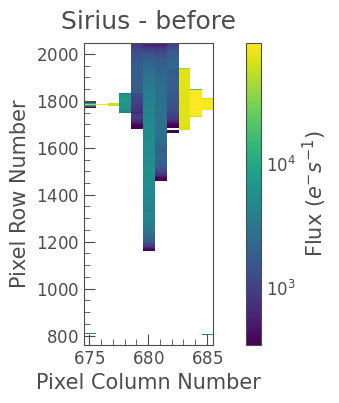

In [4]:
tpf.plot(aspect=0.02,scale = 'log',interpolation='nearest',title='Sirius - before');

## Use `mundey` to recalibrate TPF

In [5]:
tpf.calibrate()

Beginning calibration of * alf CMa
Sector: 6
Camera: 2
CCD: 3
Outputs: {'B'}

Loading collatoral target pixel files
... loading smear row file ./tess2018349182459-s0006-smrow-2-3-b-0126-s_col.fits
... loading trailing virtual column file ./tess2018349182459-s0006-tvcol-2-3-b-0126-s_col.fits

Adjusting for fixed offset and mean black - Output B

Loading 2D black model
... ./tess2018323-2-3-2dblack.fits
Performing 2-D black correction

Performing 1-D black correction
... this step may take a while;
... if you haven't already done so
... you might like to take this opportunity
... to join your union.


Frame 0 of 100


/home/tim/.local/lib/python3.6/site-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)



Correcting for non-linearity and gain

Correcting for LDE undershoot

Correcting for photometric smear

Loading flat field
... ./tess2018323-2-3-flat.fits
Performing flatfield correction

Converting to electrons per second

Calibration Complete


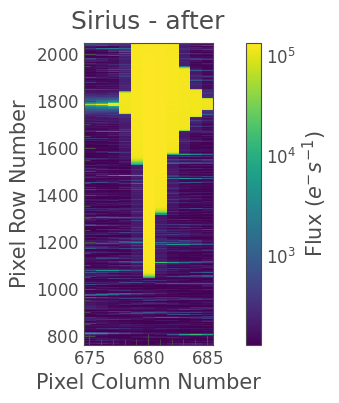

In [6]:
tpf.plot(aspect=0.02,scale = 'log',interpolation='nearest',title='Sirius - after');

In [7]:
np.nansum(tpf.flux.value)

41293316000.0

## Use `tessbkgd` to estimate the background

In [8]:
tpf.__class__ = tessbkgd.tessbkgd.bkgd_tpf

In [9]:
newbkgd,bkgdmask = tpf.get_bkgd()

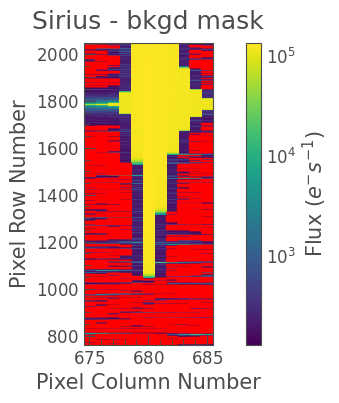

In [10]:
tpf.plot(aspect=0.02,scale = 'log',interpolation='nearest',title='Sirius - bkgd mask',aperture_mask = bkgdmask);

In [11]:
if np.nansum(tpf.flux_bkg) == 0:  #No background previously set
    tpf.flux = tpf.flux - newbkgd
    tpf.flux_bkg = newbkgd
else:    #Need to add old background back in
    tpf.flux = tpf.flux + tpf.flux_bkg - newbkgd
    tpf.flux_bkg = newbkgd

## Use `halophot` to calculate light curve

In [12]:
tpf.__class__ = halophot.halo_tools.halo_tpf_tess

In [13]:
halomask = np.ones((tpf.flux.shape[1],tpf.flux.shape[2]),dtype='bool')

yy,xx = np.meshgrid(np.arange(halomask.shape[0]),np.arange(halomask.shape[1]))

row1 = 1700
row2 = 1875
y1 = tpf.hdu[2].header['CRVAL2P']-1

halomask[(yy<row1-y1).T] = False
halomask[(yy>row2-y1).T] = False

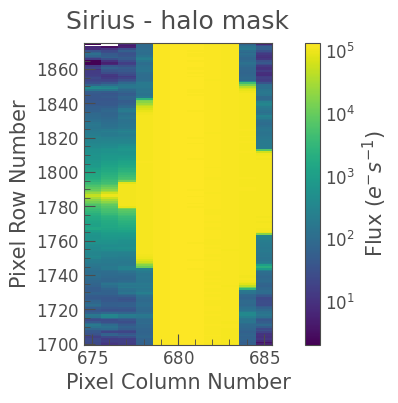

In [14]:
ax = tpf.plot(aspect=0.1,scale = 'log',interpolation='nearest',title='Sirius - halo mask')
ax.set_ylim(row1-0.5,row2+0.5)
plt.show()

In [15]:
%%time
weightmap, corr_lc = tpf.halo(objective='tv',mask=halomask,minflux=0,thresh=0.9)

Taking cadences from beginning to end
696 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
CPU times: user 1.47 s, sys: 823 ms, total: 2.29 s
Wall time: 839 ms


/usr/local/lib/python3.6/dist-packages/halophot-0.7.4-py3.6.egg/halophot/halo_tools.py:1246: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/api/lightkurve.lightcurve.LightCurve.html
/usr/local/lib/python3.6/dist-packages/halophot-0.7.4-py3.6.egg/halophot/halo_tools.py:1247: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/api/lightkurve.lightcurve.LightCurve.html
/usr/local/lib/python3.6/dist-packages/halophot-0.7.4-py3.6.egg/halophot/halo_tools.py:1248: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.l

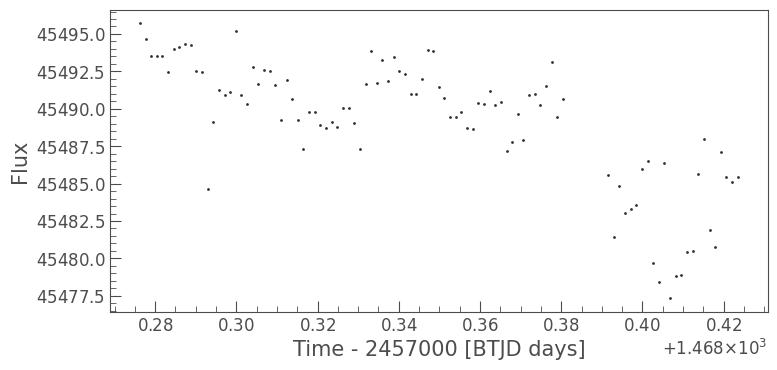

In [16]:
corr_lc.scatter();